# Example 1

## Problem

$$(OCP)_1\left\{\begin{array}{l}
Min \int_0^{t_f}x\sqrt{1+u^2}dt\\
\dot{x} = u\\
u\in\R
\end{array}
\right.$$

In [1]:
using Pkg
Pkg.activate(".")
#
using OptimalControl
using LinearAlgebra
using ForwardDiff
using DifferentialEquations
using Roots     # solve an equation f(x)=0 where f is from R to R
using LaTeXStrings
using Plots
using Test

  Activating project at `~/control-toolbox/indirect`


## Control-toolbox definition of the problem

In [2]:
t0 = 0
tf = 2
x0 = 1
xf = 1
@def ocp begin
    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    ẋ(t) ==  u(t)
    ∫(x(t)*(1 + u(t)^2)^(1/2)) → min
end

t ∈ [t0, tf], time
x ∈ R, state
u ∈ R, control
x(t0) == x0
x(tf) == xf
ẋ(t) == u(t)
∫(x(t) * (1 + u(t) ^ 2) ^ (1 / 2)) → min



┌───────┬───────┬─────────┬──────────┬───────────┬─────────────┐
│ times │ state │ control │ dynamics │ objective │ constraints │
├───────┼───────┼─────────┼──────────┼───────────┼─────────────┤
│    ✅ │    ✅ │      ✅ │       ✅ │        ✅ │          ✅ │
└───────┴───────┴─────────┴──────────┴───────────┴─────────────┘


## Hamiltonian flow
The Hamiltonian is
$$H(x,u,p) =  -x\sqrt{1+u^2} + up,$$
and for $|p| < |x|$ the maximization of the Hamiltonian have the solution
$$u(x,p) = sign(x)p\sqrt{1. /(x^2-p^2)}.$$
Then the true Hamiltonian is $H_r(x,p)=H(x,u(x,p),p)$. 

We note $z(t) = (x(t),p(t))$, then the hamiltonian flow is the function
$\phi(.,z_0) = \phi(.,x_0,p_0)$ solution of the initial value problem
$$(IVP)\left\{
\begin{array}{l}
\dot{z} = \vec{H}(z) = \begin{pmatrix}
\dot{x}\\ \dot{p}
\end{pmatrix} =
\begin{pmatrix}
\dfrac{\partial H(z)}{\partial p}\\
-\dfrac{\partial H(z)}{\partial x}
\end{pmatrix}\\
z(0) = z_0 = (x_0,p_0).
\end{array}
    \right.$$

In [3]:
# Compute the  Flow
# contol function
u(x, p) = sign(x[1])*p[1]*sqrt(1. /(x[1]^2-p[1]^2))  

# the Flow function computes the hamiltonian flow
ocp_flow = Flow(ocp, u)
nothing

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/gergaud/.julia/packages/SciMLBase/xNo9N/src/performance_warnings.jl:32


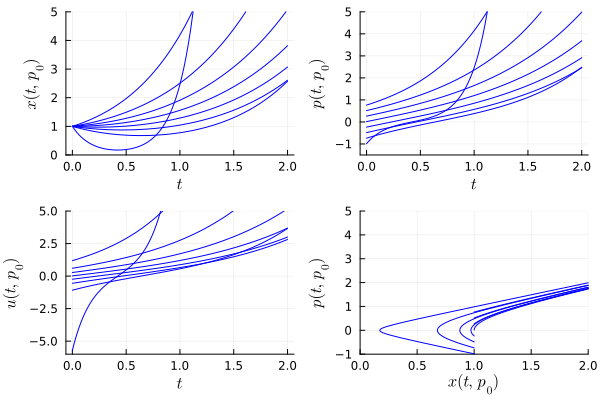

In [4]:

# ocp_flow.ode_sol is the result of the solve function from the DifferentailEquations package

# Compute flows for different value of the initial costate $p_0
Int_p0 = -0.985:0.25:0.98   # intervalle of p_0
Δt = (tf - t0)/100          # 
plt_x = plot()          # plot of the state x(t)
plt_p = plot()          # plot of the costate p(t)
plt_u = plot()          # plot of the control u(t)
plt_phase = plot()      # plot (x,p)
my_color = :blue
for p0 in Int_p0        # plot for each p_0 in Int_p0 
    flow_p0 = ocp_flow((t0, tf), x0, p0, reltol = 1e-8, abstol = 1e-8, saveat = Δt)
    T = flow_p0.ode_sol.t
    X = flow_p0.ode_sol[1,:]
    P = flow_p0.ode_sol[2,:]
    par = atanh(p0./x0)
    plot!(plt_x,T,X,color = my_color)
    plot!(plt_p,T,P,color = my_color)
    plot!(plt_u,T,u.(X,P),color = my_color)  
    plot!(plt_phase,X,P,color = my_color)      
end

# Plots
plot!(plt_x,xlabel = L"t",ylabel=L"x(t,p_0)",legend=false, ylims=(0.,5.))
plot!(plt_p,xlabel = L"t",ylabel=L"p(t,p_0)",legend=false, ylims=(-1.5,5.))
plot!(plt_u,xlabel = L"t",ylabel=L"u(t,p_0)",legend=false, ylims=(-6.,5.))
plot!(plt_phase,xlabel = L"x(t,p_0)",ylabel=L"p(t,p_0)",legend=false, xlims=(0.,2.), ylims=(-1.,5.))

fig1_example1 = plot(plt_x,plt_p,plt_u,plt_phase,layout = (2,2))
Plots.pdf(fig1_example1, "./fig-example1/fig1_example1.pdf")
plot(fig1_example1)

## Conjugate points
The time $\tau$ is said to be conjugate to the the time $t_0=0$ if the solution of the Jacobi equation
$$
\dot{\delta z}(t) = \dfrac{\partial \vec{H}}{\partial z}(z(t,z_0))\delta z(t)
$$
with the initial condition
$\delta z(0) = \begin{pmatrix}0\\1
\end{pmatrix}$, is vertical at time $\tau$, that is $\delta x(\tau) = 0$.

We first compute by automatic differentiation the flow of the Jacobi equation with the initial condition 
$$\delta z(t,x_0,p_0)=\dfrac{\partial z}{\partial p_0}z(t,x_0,p_0)$$ 


In [5]:
#
# Conjugate points

"""
    Compute the flow of the Jacobi equation for the initial condition δz(0) = (0,1)
    sol = flow_jacobi(T,x0,p0)
    input : 
    T : time where we want δz(t) 
        list or array (t0,t1,...,tN)
    x0 : initial state
         Real(n), here a real
    p0 : initial costate
         Real(n), here a real
    output : 
    sol : (δz(t0),δz(t1),...,δz(tN))
          Vector of vector of dimension 2n, the type of the element are the same as the type of p0 because we use after the automatic differentiation.
          To modifie if n > 1

"""


"    Compute the flow of the Jacobi equation for the initial condition δz(0) = (0,1)\n    sol = flow_jacobi(T,x0,p0)\n    input : \n    T : time where we want δz(t) \n        list or array (t0,t1,...,tN)\n    x0 : initial state\n         Real(n), here a real\n    p0 : initial costate\n         Real(n), here a real\n    output : \n    sol : (δz(t0),δz(t1),...,δz(tN))\n          Vector of vector of dimension 2n, the type of the element are the same as the type of p0 because we use after the automatic differentiation.\n          To modifie if n > 1\n\n"

In [6]:

function flow_jacobi(tspan,x0,p0)

    flow_p0(p_0) = ocp_flow(tspan, x0, p_0, reltol = 1e-10, abstol = 1e-10).ode_sol.u[end]
    return ForwardDiff.derivative(flow_p0, p0)
end


flow_jacobi (generic function with 1 method)

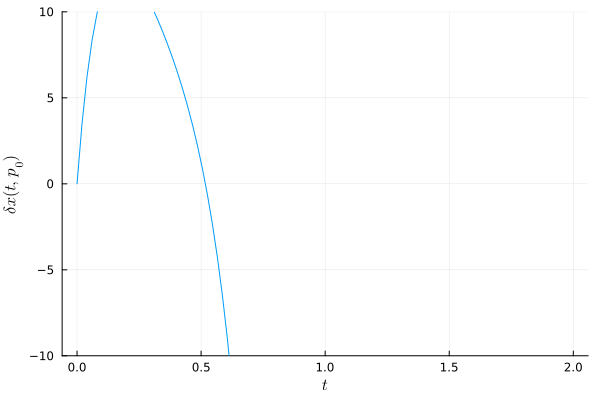

In [7]:

p0 = -0.985
t0tf = (0., 2.)

Int_t0tf = range(t0,stop=tf,length=100)
n_t = length(Int_t0tf)
Sol = zeros(n_t,2)
for i in 1:n_t
    Sol[i,:] = flow_jacobi((t0,Int_t0tf[i]),x0,p0)
end
plt_conj1 = plot()
plot!(plt_conj1,Int_t0tf,Sol[:,1])  # as n=1 the det is the number
plot!(plt_conj1,xlabel = L"t",ylabel=L"\delta x(t,p_0)",legend=false, ylims=(-10.,10.))

Plots.pdf(plt_conj1, "./fig-example1/fig2_example1.pdf")
plot(plt_conj1)


Then we numerically compute the conjugate point by solving $\delta x(t)=\delta z(t,x_0,p_0)_1=0$, for $x_0=1.$ and $p_0=0.985$.

In [8]:
# compute the fisrt conjugate time 
delta_x(tau) = flow_jacobi((t0,tau),x0,p0)[1]
using Roots
tau0 = find_zero(delta_x, (0.4, 0.6))

0.51728931341542

For p0 = -0.985

 tau_0 = 0.51728931341542


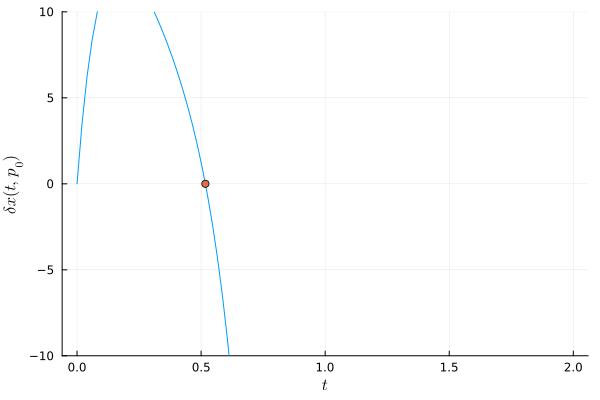

In [9]:

println("For p0 = ", p0, " tau_0 = ", tau0)

plot!(plt_conj1,[tau0],[flow_jacobi((t0,tau0),x0,p0)],seriestype=:scatter)
Plots.pdf(plt_conj1, "./fig-example1/fig3_example1.pdf")
plot(plt_conj1)

## Compute the conjugate loci
We compute conjugate loci by path following algorithm

We define $F(\tau,p_0) = \delta x(\tau,p_0)$ and we suppose that 
$\dfrac{\partial F}{\partial\tau}(\tau,p_0)$ is  inversible, then by the implicit function theorem the conjugate time is a function of $p_0$. So, as here $p_0\in\R$, we can compute them by solving the initial value problem
$$(IVP_{conj.points})\left\{
\begin{array}{l}
\dot{\tau} = -\dfrac{\partial F}{\partial\tau}(\tau,p_0)^{-1}\dfrac{\partial F}{\partial p_0}(\tau,p_0)\\
\tau(p_0) = \tau_0.
\end{array}
    \right.$$

### Remark
The derivative $\dfrac{\partial F}{\partial\tau}(\tau,p_0) = \dfrac{\partial \delta x}{\partial\tau}(\tau,p_0)$ is equal to  the first component of the second member of the Jacobi equation
$\dfrac{\partial \vec{H}}{\partial z}(z(t,z_0))\delta z(t)$.


In [10]:
# right hand side of the hamiltonian flow
Hvec! = ocp_flow.rhs!

#conjugates points by path following
"""
    Compute the right hand side of the conj.points IVP equation
    tau_point = rhs_path(tau , par, p0)
    For the structure of the rhs_path see DifferentialEquaions package
"""
function rhs_path(tau , par, p0)
    n = length(p0)
    tau1 = tau[1]     # tau is a vector
    z0 = [x0,p0]
    zpoint = similar(z0)
    Hvec!(zpoint,z0) = ocp_flow.rhs!(zpoint,z0,par,tau1)
    # zpoint is the second member of the Hamiltonian flow
    Hvec!(zpoint,z0)     
    dHvec = Matrix{typeof(p0[1])}(undef,2n,2n) # Matrix (2*n,2*n)
    # compute z(tau)
    z = ocp_flow((t0, tau1), x0, p0, reltol = 1e-8, abstol = 1e-8).ode_sol(tau1) 
  
    #derivative w.r.t. tau
    ForwardDiff.jacobian!(dHvec,Hvec!,zpoint,z) 
    delta_z = flow_jacobi((t0,tau1),x0,p0)
    dd_tau = (dHvec*delta_z)[1]    

    #derivative w.r.t. p0  
    Ftau(p0) = flow_jacobi((t0,tau1),x0,p0)[1]
    dd_p0 = ForwardDiff.derivative(Ftau, p0) 
    return [-(1/dd_tau)*dd_p0]
end

rhs_path

In [11]:
"""
   Compute the conjugate times by path by integration of the (IVP_conj.points) problem
"""
function conj_point(p0span, tau0)
    #
    pb = ODEProblem(rhs_path,[tau0],p0span,[1.])
    sol = DifferentialEquations.solve(pb, reltol = 1e-8, abstol = 1e-8)
    return sol
end


conj_point

p0 = -0.985
0.51728931341542

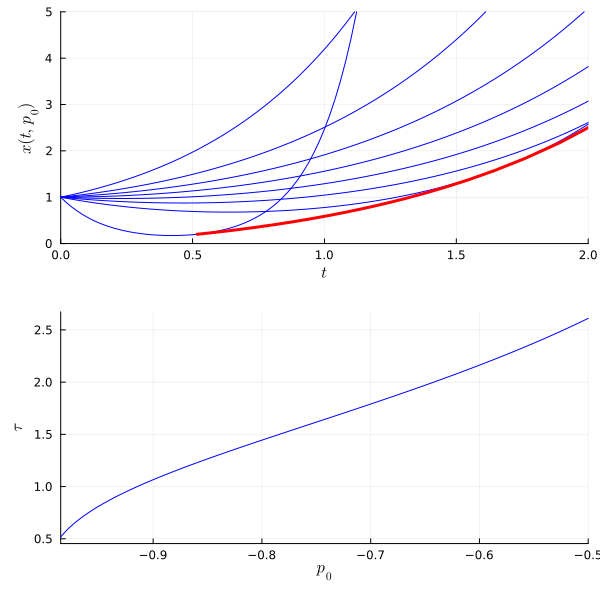

In [12]:

# conjugate point

println("p0 = ", p0)
println(tau0)

p0span = (p0, -0.5)
sol = conj_point(p0span,tau0)
plt_conj_point = plot(sol,xlabel = L"p_0", ylabel = L"\tau",color=my_color)
TT = sol.u              # conjugate times
nb_t = length(sol.t)
T = zeros(nb_t)
X = zeros(nb_t)
for i in 1:nb_t
    T[i] = TT[i][1]      # τ
                         # sol.t[i] = p0
    X[i] = ocp_flow((t0, T[i][1]), x0, sol.t[i], reltol = 1e-8, abstol = 1e-8, saveat = Δt).ode_sol[1,end] # state at the conjugate time 
end

plot!(plt_x,T,X,linewidth=3,color = :red, legend=false, xlims=(0.,2.0), ylims=(0.,5.))
plt_conj2 = plot(plt_x,plt_conj_point,layout = (2,1),legend=false,size=(600,600))
Plots.pdf(plt_conj2, "./fig-example1/fig4_example1.pdf")
plot(plt_conj2)